In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import math

import os


2025-04-22 21:21:39.791229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 21:21:40.033842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745331700.119295    4356 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745331700.143503    4356 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745331700.323183    4356 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Path to dataset
dataset_path = 'dataset/'

In [3]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4183 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.


In [5]:
# Load EfficientNetB0 (without classifier top)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

I0000 00:00:1745331714.897031    4356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Callback
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

In [9]:
# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

/home/abx31/cnn-covid-detection/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1745331722.000588    4501 service.cc:152] XLA service 0x7f669c001e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745331722.000618    4501 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-04-22 21:22:02.266017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745331723.709195    4501 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-22 21:22:06.856722: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng4{} for conv %cudnn-conv.119 = (f32[32,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0} %bitcast.25436, f32[32,1,3,3]{3,2,1,0} %bitcast.25440), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", metadata={op_type="Depthwi

  1/131 ━━━━━━━━━━━━━━━━━━━━ 36:06 17s/step - accuracy: 0.3438 - loss: 1.1550

I0000 00:00:1745331734.508206    4501 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.3423 - loss: 1.1424 - val_accuracy: 0.3445 - val_loss: 1.0985 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.3213 - loss: 1.1004 - val_accuracy: 0.3445 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.3385 - loss: 1.0980 - val_accuracy: 0.3445 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - accuracy: 0.3594 - loss: 1.0977 - val_accuracy: 0.3445 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.3430 - loss: 1.0975 - val_accuracy: 0.3445 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.3343 - loss: 1.0980 - val_accuracy: 0.3445 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.3417 - loss:

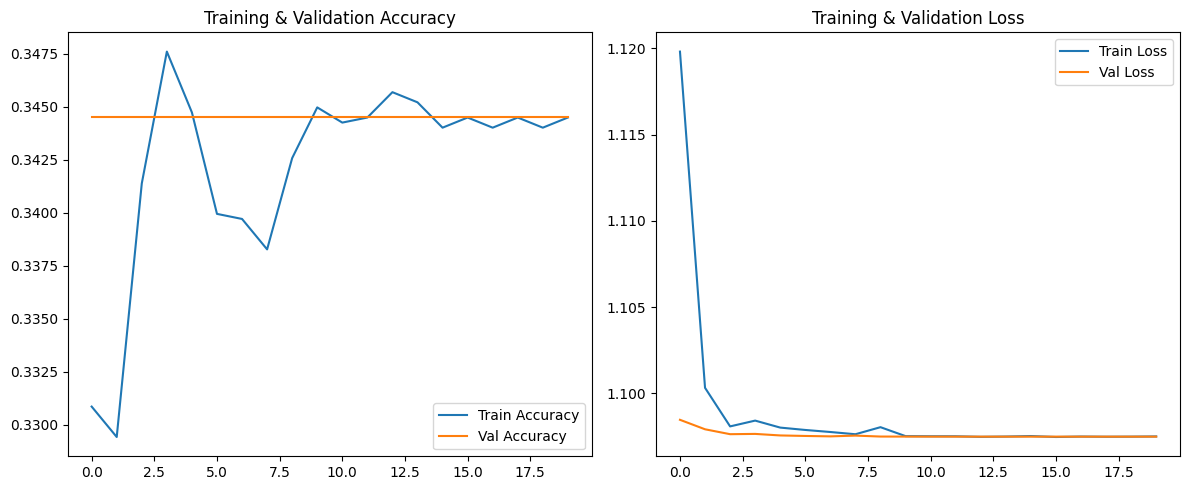

In [10]:
# Create graph for accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [11]:
# Data Validation predict
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step


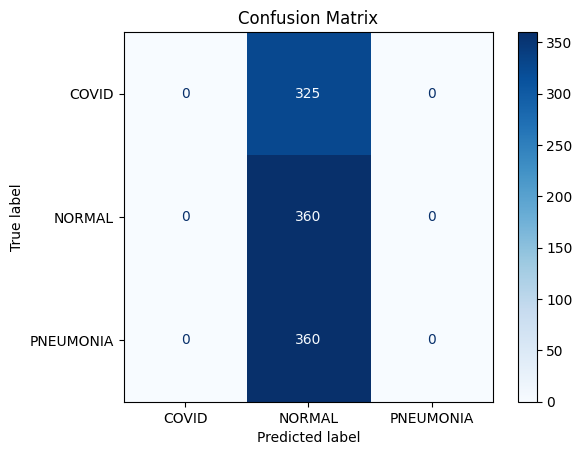

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       325
      NORMAL       0.34      1.00      0.51       360
   PNEUMONIA       0.00      0.00      0.00       360

    accuracy                           0.34      1045
   macro avg       0.11      0.33      0.17      1045
weighted avg       0.12      0.34      0.18      1045



/home/abx31/cnn-covid-detection/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abx31/cnn-covid-detection/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abx31/cnn-covid-detection/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [14]:
# Optional: Entropy and Loss Report
def categorical_crossentropy_loss(y_true, y_pred, epsilon=1e-10):
    y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = -np.sum(y_true_onehot * np.log(y_pred)) / y_pred.shape[0]
    return loss

In [15]:
entropy = categorical_crossentropy_loss(y_true, Y_pred)
print(f"Manual Entropy (Categorical Crossentropy): {entropy:.4f}")

Manual Entropy (Categorical Crossentropy): 1.0975


In [16]:
# Save model
model.save("model_covid_classifier.h5")

# Check mapping class
print("Class mapping:", train_generator.class_indices)

Class mapping: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
